<div align="center">
      <h1>Introduction to Linear Classifiers</h1>
      <hr>
      <p>While the k-NN classifier offers a straightforward concept, it comes with a computational cost during testing. Coupled with its suboptimal performance in real-world scenarios, this underscores the necessity for a more efficient classifier. In this assignment, you will delve into the implementation of a linear classifier, training it using stochastic gradient descent (SGD). This foundational step will naturally lead to the exploration of neural networks in the subsequent assignment. Additionally, you will delve into the considerations when selecting the learning rate and regularization strength, along with visualizing the classifier's learned weights.</p>
</div>


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### The Data We'll Use

We will continue using the same dataset employed with the k-NN classifier. This choice enables a direct comparison between the two classifiers. The dataset is referred to as linearly separable due to the ability to draw a lines that almost perfectly separates classes. It's important to note that this is not always the case; sometimes, classes are not linearly separable. In such instances, a linear classifier is not suitable, and we will delve into alternative approaches in the next assignment. For now, let's load the dataset and visualize it.

---------------- Training data ----------------
X_train shape: (1125, 2), y_train shape: (1125,)

---------------- Validation data ----------------
X_val shape: (187, 2), y_val shape: (187,)

---------------- Testing data ----------------
X_test shape: (188, 2), y_test shape: (188,)

---------------- Dataset info ----------------
Number of features: 2
Number of classes: 3
Number of samples in training set: 1125, which is 75.00% of the dataset
Number of samples in validation set: 187, which is 12.47% of the dataset
Number of samples in testing set: 188, which is 12.53% of the dataset
Number of samples in dataset: 1500


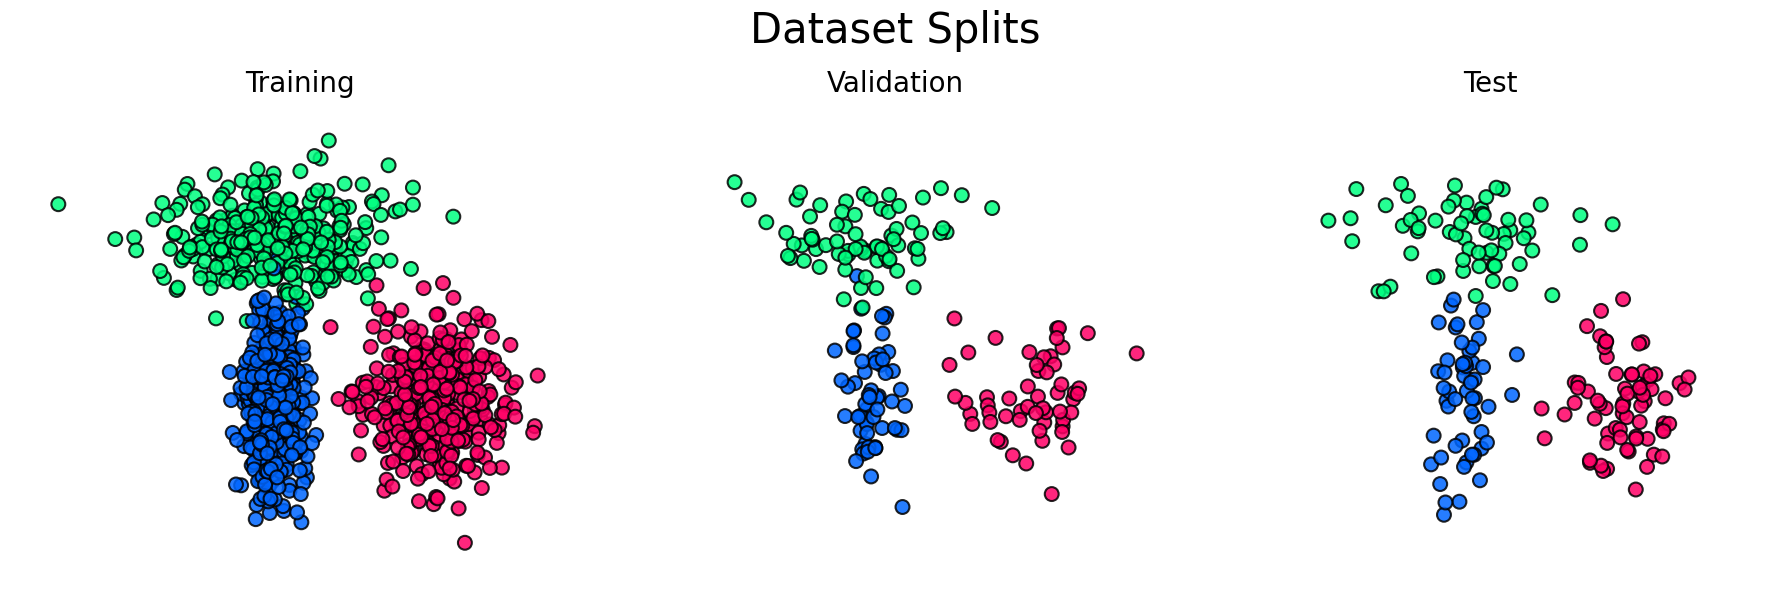

In [10]:
from utils.visualizer import Visualizer

# Load the dataset
dataset = np.load('data/datasets/linearly_separable.npz')

X_train = dataset['X_train']
y_train = dataset['y_train']

X_val = dataset['X_val']
y_val = dataset['y_val']

X_test = dataset['X_test']
y_test = dataset['y_test']

# Print the shapes of the data
print('---------------- Training data ----------------')
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')

print('\n---------------- Validation data ----------------')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')

print('\n---------------- Testing data ----------------')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

print('\n---------------- Dataset info ----------------')
print(f'Number of features: {X_train.shape[1]}')
print(f'Number of classes: {len(np.unique(y_train))}')
print(f'Number of samples in training set: {len(X_train)}, '
      f'which is {100 * len(X_train) / (len(X_train) + len(X_val) + len(X_test)):.2f}% of the dataset')
print(f'Number of samples in validation set: {len(X_val)}, '
      f'which is {100 * len(X_val) / (len(X_train) + len(X_val) + len(X_test)):.2f}% of the dataset')
print(f'Number of samples in testing set: {len(X_test)}, '
      f'which is {100 * len(X_test) / (len(X_train) + len(X_val) + len(X_test)):.2f}% of the dataset')
print(f'Number of samples in dataset: {len(X_train) + len(X_val) + len(X_test)}')

visualizer = Visualizer((X_train, y_train), (X_val, y_val), (X_test, y_test))
visualizer.show_dataset()

## Linear Classifier

As previously mentioned, a classifier can be viewed as a function denoted as $f$, which maps features to corresponding labels. This concept can be expressed as:

$$f: \mathbb{R}^{d} \rightarrow \mathcal{Y}$$

$$f(\boldsymbol{x}) = y, \quad \boldsymbol{x} \in \mathbb{R}^{d}, \quad y \in \mathcal{Y}$$

To illustrate this, consider a binary classification scenario with classes `dog` and `cat`. Our features consist of the animal's `height` and `weight`. In this context, we desire a function:

$$f: \mathbb{R}^{2} \rightarrow \mathcal{Y}$$
$$f(\text{height}, \text{weight}) = \begin{cases} 1, & \quad \text{if dog} \\ 0, & \quad \text{if cat} \end{cases}$$

However, there are situations where we seek more than just a class label; we want something known as a **score vector**. This vector comprises scores for each class, typically denoted as $\boldsymbol{s}$, with individual class scores represented as $s_i$. The class with the highest score becomes our prediction.

Why is this score vector useful? It allows us to assess the classifier's confidence in its prediction. When uncertainty arises, we can opt not to make a prediction, a valuable feature in applications like medicine where mistakes must be minimized. Additionally, the score vector facilitates classifier training. By comparing these scores with true labels, we can gauge prediction accuracy. In essence, to compute the score vector, we aim for a function like this:

$$\boldsymbol{f}: \mathbb{R}^{d} \rightarrow \mathbb{R}^{c}$$
$$\boldsymbol{f}(\boldsymbol{x}) = \boldsymbol{s}, \quad \boldsymbol{x} \in \mathbb{R}^{d}, \quad \boldsymbol{s} \in \mathbb{R}^{c}$$
$$y = \arg\max (\boldsymbol{s}), \quad \boldsymbol{s} = (s_1, s_2, \dots, s_c), \quad y \in \mathcal{Y} = \{1, 2, \dots, c\}$$

where $c$ represents the number of classes. In our binary example, $c = 2$.

Now, to realize this function, we employ the linear function—hence the term "linear classifier". The linear function is defined as:

$$\boldsymbol{f}(\boldsymbol{x}) = \boldsymbol{W} \boldsymbol{x} + \boldsymbol{b}, \quad \boldsymbol{x} \in \mathbb{R}^{d}, \quad \boldsymbol{W} \in \mathbb{R}^{c \times d}, \quad \boldsymbol{b} \in \mathbb{R}^{c}$$

Here, $\boldsymbol{W}$ denotes a matrix of size $c \times d$, and $\boldsymbol{b}$ is a vector of size $c$. These two components, the weights matrix and the bias vector, constitute the classifier's parameters. We will learn these parameters through training data. It's also worth noting that the linear function is often referred to as the affine function, and consequently, the linear classifier is sometimes called the affine classifier.

Armed with this understanding, your task is to implement the `compute_scores` function within the `LinearClassifier` class found in the `linear_classifier.py` file. This function should accept a batch of inputs `X` and return the score vector `s`. To achieve this, utilize the weights matrix `self.W` and the bias vector `self.b` in the computation of the score vector.

## Loss Function

The loss function serves as a vital metric for assessing the accuracy of a classifier's predictions. It takes two inputs: the score matrix $\boldsymbol{S}$ and the true labels $\boldsymbol{y}$, yielding a single numeric value. The loss function is mathematically expressed as:

$$L(\boldsymbol{S}, \boldsymbol{y}) = \frac{1}{n} \sum_{i=1}^{n} L_i(\boldsymbol{s}_i, y_i)$$

In this exercise, we will employ the cross-entropy loss function, depicted as:

$$L(\boldsymbol{S}, \boldsymbol{y}) = - \frac{1}{n} \sum_{i=1}^{n} \log \frac{e^{s_{i, y_i}}}{\sum_{j=1}^{c} e^{s_{i, j}}}$$

While this formula might appear daunting initially, it's fundamentally straightforward. Let's break it down step by step. The loss function $L(\boldsymbol{S}, \boldsymbol{y})$ computes the average of the individual loss function $L_i(\boldsymbol{s}_i, y_i)$ for each sample $i$. The loss function $L_i(\boldsymbol{s}_i, y_i)$ pertaining to a single sample $i$ is defined as:

$$L_i(\boldsymbol{s}_i, y_i) = - \log \frac{e^{s_{i, y_i}}}{\sum_{j=1}^{c} e^{s_{i, j}}} = - \log p_{i, y_i}$$

In this equation, $p_{i, y_i}$ represents the probability of the correct class $y_i$ for sample $i$, calculated using the softmax function:

$$p_{i, y_i} = \frac{e^{s_{i, y_i}}}{\sum_{j=1}^{c} e^{s_{i, j}}}$$

Now, let's focus on the negative logarithm of the probability, denoted as $- \log p_{i, y_i}$. This quantity is always positive, as the negative logarithm of a number between 0 and 1 ensures positivity. Moreover, it exhibits an interesting behavior: as the probability $p_{i, y_i}$ approaches 1, the negative logarithm decreases, and conversely, as the probability approaches 0, the negative logarithm increases. This characteristic aligns with our objective – we desire the loss function $L_i(\boldsymbol{s}_i, y_i)$ to be substantial when the classifier lacks confidence in the correct class prediction, and conversely, small when the classifier is confident in its prediction for the correct class.

For those curious about the logarithm's origin, it arises from the definition of cross-entropy:

$$H(p, q) = - \sum_{x} p(x) \log q(x)$$

Here, $p$ represents the true distribution, while $q$ is the predicted distribution. In our scenario, the true distribution corresponds to the one-hot vector $\boldsymbol{y}_{i}$, and the predicted distribution aligns with the softmax vector $\boldsymbol{p}_{i}$. It's important to note that the $p$ in cross-entropy differs from the probability $p_{i, y_i}$, serving distinct roles in the context.

## Training the Linear Classifier

Now that we have a loss function, we can train the linear classifier. To achieve this, we will employ a technique known as stochastic gradient descent (SGD). SGD is an iterative algorithm that updates the classifier's parameters in the direction of the negative gradient of the loss function. This process continues until the loss function converges to a minimum. 

Now open the `train` function within the `LinearClassifier` class and implement the SGD algorithm. Use the `Tensor` class you have implemented in the previous homework.

In [11]:
import pickle
from sklearn.metrics import accuracy_score
from assignments.linear_classifier import LinearClassifier

# create a linear classifier
linear_classifier = LinearClassifier(num_features=2, num_classes=3, learning_rate=1e-1,
                                     num_iters=1000, batch_size=500,
                                     verbose=True)

# train the classifier
linear_classifier.train(X_train, y_train)

# predict labels for the training set
y_pred = linear_classifier.predict(X_val)
print(f'Accuracy: {accuracy_score(y_val, y_pred):.2f}')

# Save the model weights
with open("data/models/linear_classifier.pkl", "wb") as f:
    pickle.dump(linear_classifier, f)

iteration 0 / 1000: 1.098615100475552
iteration 100 / 1000: 0.510929640950774
iteration 200 / 1000: 0.3655633436094146
iteration 300 / 1000: 0.30146241654204914
iteration 400 / 1000: 0.27213979178501974
iteration 500 / 1000: 0.23939964432757363
iteration 600 / 1000: 0.21986595022477792
iteration 700 / 1000: 0.21101861520477858
iteration 800 / 1000: 0.20461291238171384
iteration 900 / 1000: 0.20236257708460864
Accuracy: 0.97


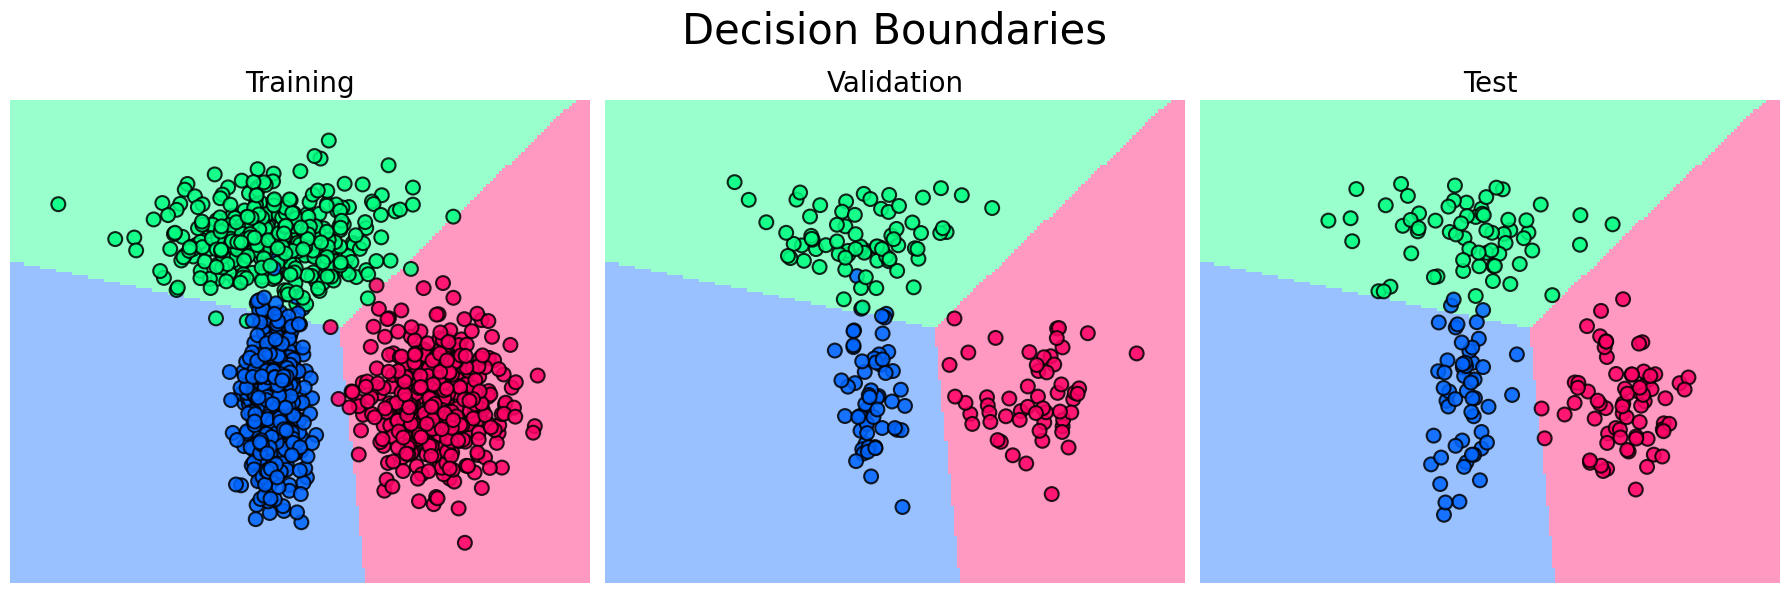

In [12]:
# %matplotlib inline
visualizer.show_decision_boundaries(linear_classifier, h=0.02)

In [14]:
visualizer.show_decision_functions(linear_classifier, 'linear')

KeyboardInterrupt: 

KeyboardInterrupt: 